# Prediction analisys

first of all we need to define the target variable. The simplest way is to

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('dataset/incident_profile_95.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CRASH_YEAR                            22516 non-null  int64  
 1   CRASH_MONTH                           22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE                    22516 non-null  float64
 3   avg_responsibility_score              22516 non-null  float64
 4   avg_weather_severity                  22516 non-null  float64
 5   avg_roadway_severity                  22516 non-null  float64
 6   avg_lighting_severity                 22516 non-null  float64
 7   total_crashes                         22516 non-null  int64  
 8   fatality_rate                         22516 non-null  float64
 9   severe_injury_rate                    22516 non-null  float64
 10  avg_crash_severity_score              22516 non-null  float64
 11  injury_severity

In [3]:
# create a towed_runit_rate column,num_towed_units_LB w.r.t. monthly_total_units
df['towed_runit_rate'] = df['num_towed_units_LB'] / df['monthly_total_units']

In [4]:
categorical_columns = [col for col in df.columns if col.startswith("sum_")]
non_categorical_columns = df.columns.difference(categorical_columns)

In [5]:
df[non_categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BEAT_OF_OCCURRENCE              22516 non-null  float64
 1   CRASH_MONTH                     22516 non-null  int64  
 2   CRASH_YEAR                      22516 non-null  int64  
 3   adverse_weather_crash_rate      22516 non-null  float64
 4   avg_age                         22516 non-null  float64
 5   avg_crash_severity_score        22516 non-null  float64
 6   avg_lighting_severity           22516 non-null  float64
 7   avg_responsibility_score        22516 non-null  float64
 8   avg_roadway_severity            22516 non-null  float64
 9   avg_weather_severity            22516 non-null  float64
 10  combined_weather_road_severity  22516 non-null  float64
 11  damage_cost_LB                  22516 non-null  int64  
 12  damage_high                     

In [6]:
columns_to_drop = ['avg_weather_severity','avg_roadway_severity', 'damage_high', 'damage_low', 'damage_medium', 'total_drivers', 'total_units_department']
df = df.drop(columns=categorical_columns + columns_to_drop)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CRASH_YEAR                      22516 non-null  int64  
 1   CRASH_MONTH                     22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE              22516 non-null  float64
 3   avg_responsibility_score        22516 non-null  float64
 4   avg_lighting_severity           22516 non-null  float64
 5   total_crashes                   22516 non-null  int64  
 6   fatality_rate                   22516 non-null  float64
 7   severe_injury_rate              22516 non-null  float64
 8   avg_crash_severity_score        22516 non-null  float64
 9   injury_severity_score           22516 non-null  float64
 10  night_crash_rate                22516 non-null  float64
 11  adverse_weather_crash_rate      22516 non-null  float64
 12  road_defect_crash_rate          

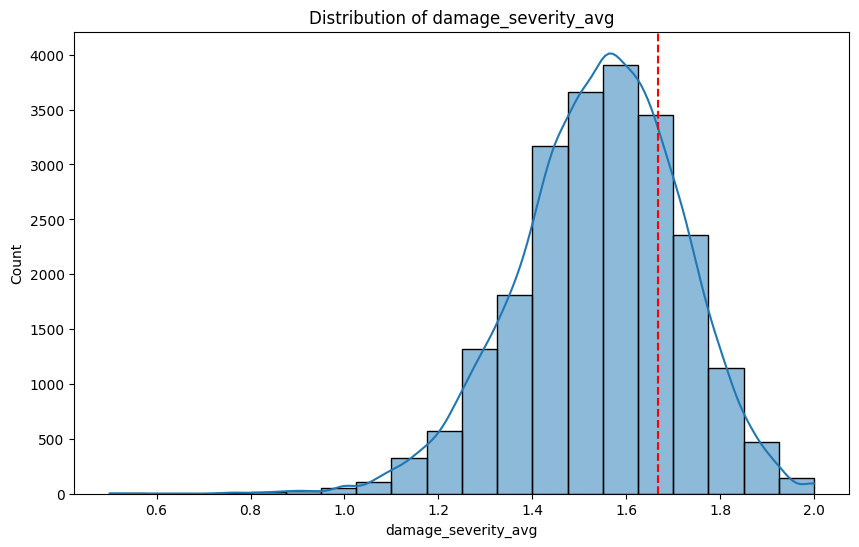

In [7]:
# distribution of damage_severity_avg
plt.figure(figsize=(10, 6))
sns.histplot(df['damage_severity_avg'], bins=20, kde=True)
plt.axvline(df['damage_severity_avg'].quantile(0.75), color='red', linestyle='--')
plt.title('Distribution of damage_severity_avg')
plt.show()


---

## Target variable definition
we will use the 75% quantile as the threshold for the damage_severity_avg, if the value is above this threshold we will consider it as a high damage and the Y value will be 1, otherwise 0


In [8]:
# first analisys using the damage_cost_LB column
df['DAMAGE_HIGH'] = df['damage_severity_avg'] > df['damage_severity_avg'].quantile(0.75)
df['DAMAGE_HIGH'] = df['DAMAGE_HIGH'].astype(int)


In [9]:
# DAMAGE columns
damage_columns = ['damage_cost_LB', 'damage_severity_avg']
df.drop(columns=damage_columns, inplace=True)
df.drop(columns=['BEAT_OF_OCCURRENCE'], inplace=True)

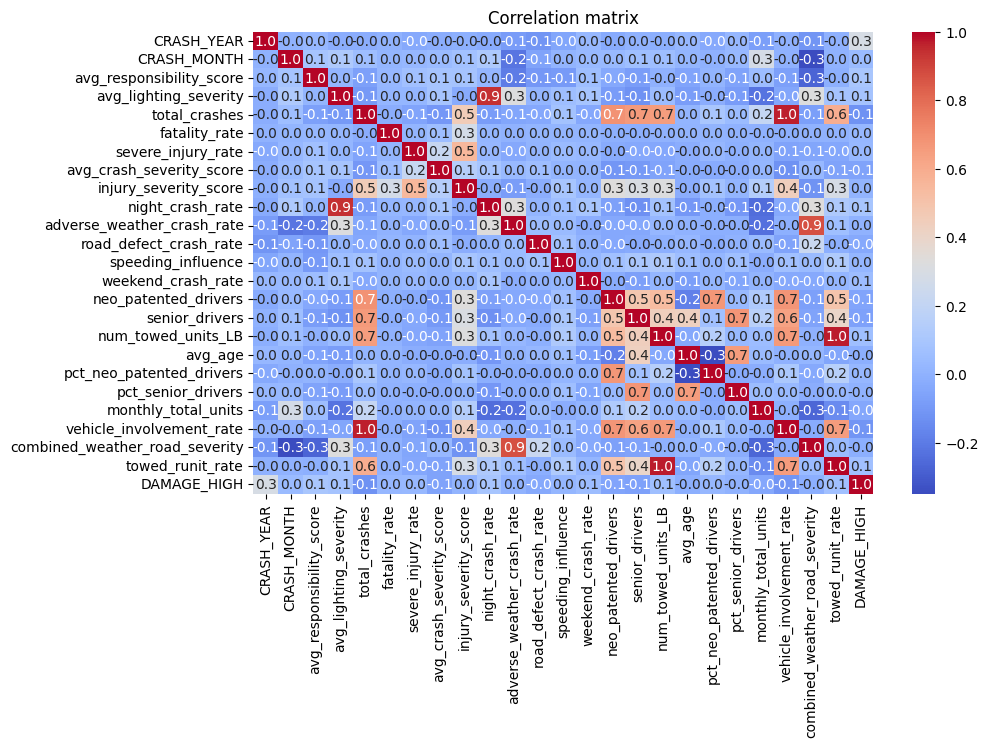

In [10]:
# correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


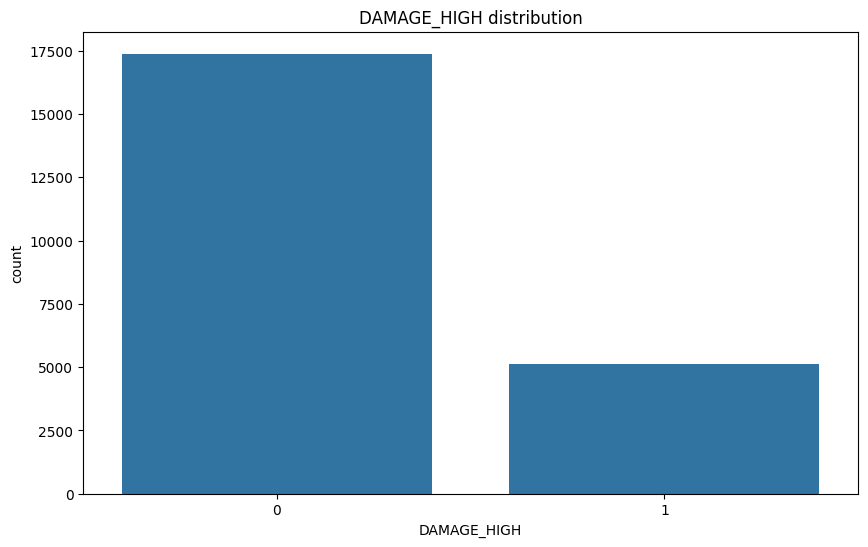

In [11]:
# plot DAMAGE_HIGH distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAMAGE_HIGH')
plt.title('DAMAGE_HIGH distribution')
plt.show()


In [12]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

In [13]:
len(df_train), len(df_test)

(19289, 3227)

In [14]:
len(df_test) / len(df_train) * 100

16.729742340193894

## X and Y features

In [15]:
X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 24), (19289,), (3227, 24), (3227,))

---

# Models

The models that we will be using will be:
- Decision Trees
- Knn
- Naive Bayes
- Random Forests
- XGBoost
- Ada Boost
- Neural Network

## Random Forest

In [16]:
np.random.seed(42)
sklearn_random_seed = 42

In [17]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

hp_dt = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
}

from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [18]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))



Train accuracy: 0.55
Test accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[1913,    0],
       [1314,    0]])

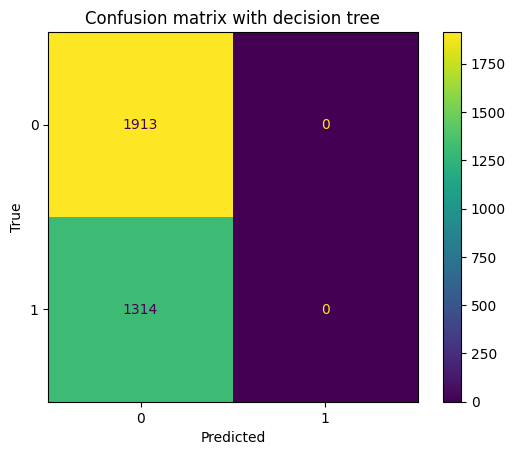

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

cm = confusion_matrix(y_test, grid_dt.predict(X_test))
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')
plt.show()

---

## KNN

In [20]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]


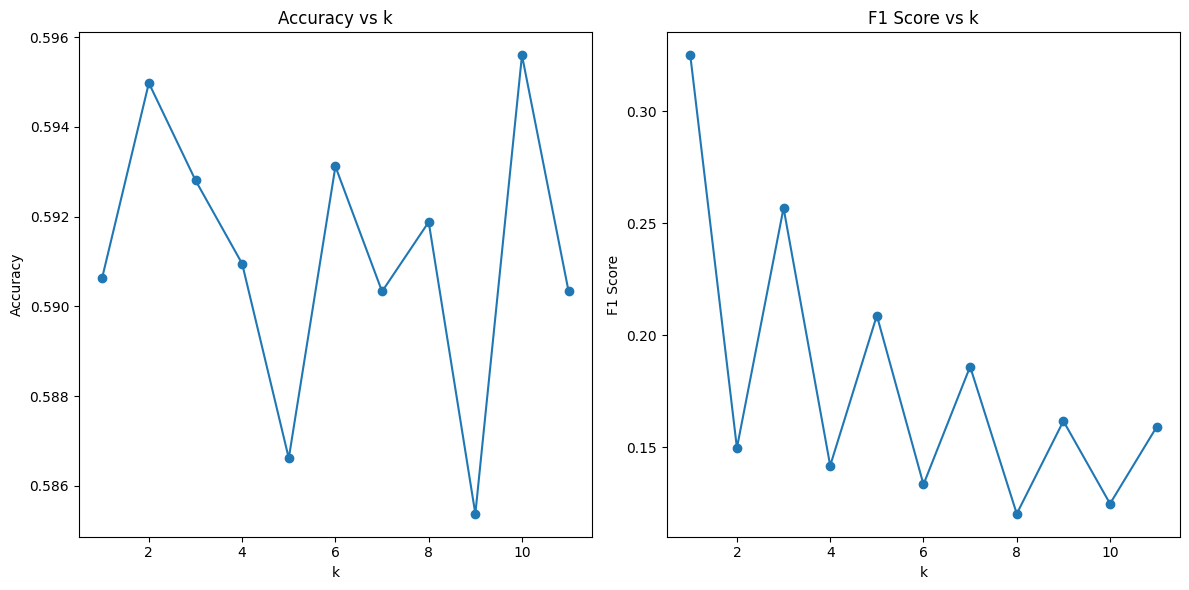

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# List of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Lists to store the results
accuracies = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Store the results
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')

plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.88      0.72      1913
           1       0.50      0.17      0.26      1314

    accuracy                           0.59      3227
   macro avg       0.55      0.53      0.49      3227
weighted avg       0.56      0.59      0.53      3227



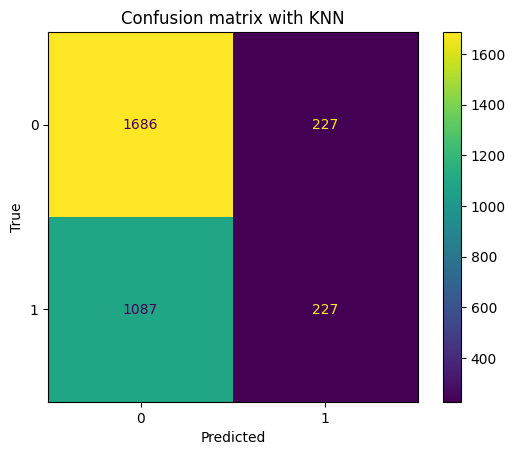

In [22]:
# confusion matrix with best k
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with KNN')
plt.show()

---

## Random Forest

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

hp_rf = {
    'n_estimators': [8, 16, 32, 64],
    'max_depth': [3, 7, 11],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

grid_rf.best_params_




Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 8}

In [24]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))

Train accuracy: 0.74
Test accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[1913,    0],
       [1314,    0]])

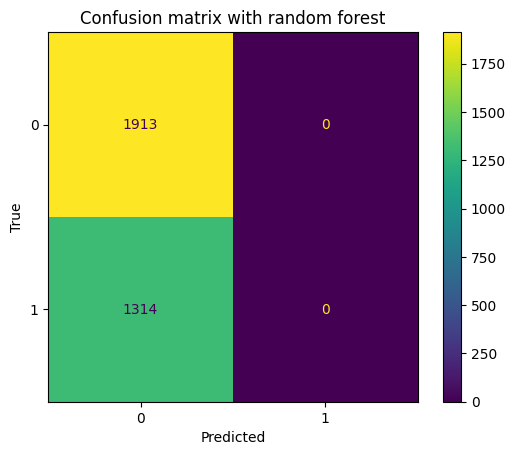

In [25]:
# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion matrix with random forest')
plt.show()

---

## feature analisys with SHAP

In [26]:
import shap

explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)

In [27]:
shap_values = explainer.shap_values(X_test)

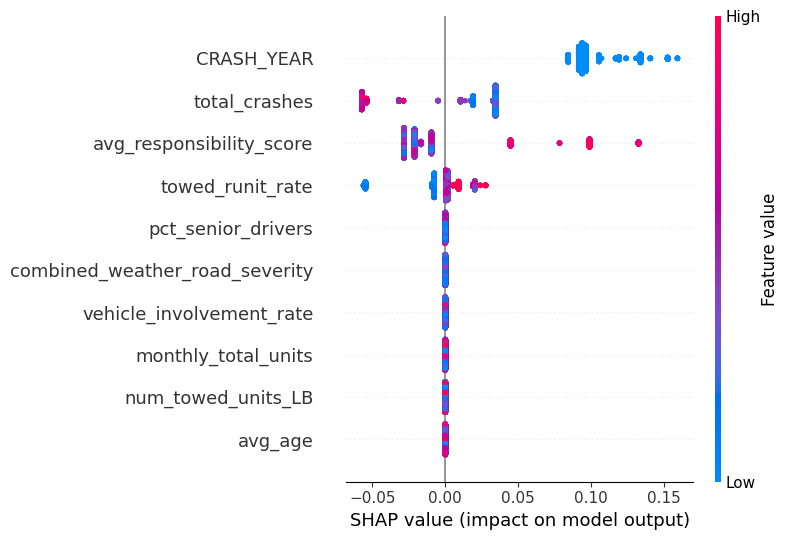

In [28]:
# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

In [29]:
df.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'total_crashes', 'fatality_rate',
       'severe_injury_rate', 'avg_crash_severity_score',
       'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'vehicle_involvement_rate', 'combined_weather_road_severity',
       'towed_runit_rate', 'DAMAGE_HIGH'],
      dtype='object')

---

# Balancing the dataset

In [30]:
# balance the training set by under-sampling the majority class

df_under = pd.concat([df_train[df_train['DAMAGE_HIGH'] == 0].sample(n=df_train['DAMAGE_HIGH'].sum(), random_state=42), df_train[df_train['DAMAGE_HIGH'] == 1]])

df_under['DAMAGE_HIGH'].value_counts()

DAMAGE_HIGH
0    3817
1    3817
Name: count, dtype: int64

In [31]:
df_under.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'total_crashes', 'fatality_rate',
       'severe_injury_rate', 'avg_crash_severity_score',
       'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'vehicle_involvement_rate', 'combined_weather_road_severity',
       'towed_runit_rate', 'DAMAGE_HIGH'],
      dtype='object')

In [32]:
X_train_under = df_under.drop(columns=['DAMAGE_HIGH'])
y_train_under = df_under['DAMAGE_HIGH']


In [33]:
# Decision Tree with under-sampling
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt_under = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt_under.fit(X_train_under, y_train_under)

grid_dt_under.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [34]:
print(f"Train accuracy: {grid_dt_under.best_score_:.2f}")
print(f"Test accuracy: {grid_dt_under.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt_under.predict(X_test)))
confusion_matrix(y_test, grid_dt_under.predict(X_test))

Train accuracy: 0.54
Test accuracy: 0.41
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1913
           1       0.41      1.00      0.58      1314

    accuracy                           0.41      3227
   macro avg       0.20      0.50      0.29      3227
weighted avg       0.17      0.41      0.24      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[   0, 1913],
       [   0, 1314]])

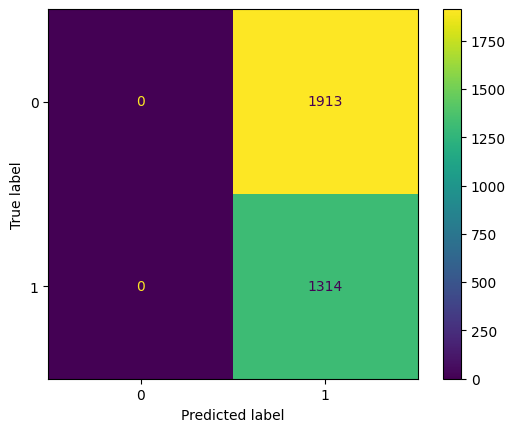

In [35]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_under = confusion_matrix(y_test, grid_dt_under.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_under, display_labels=grid_dt_under.classes_)
disp.plot()

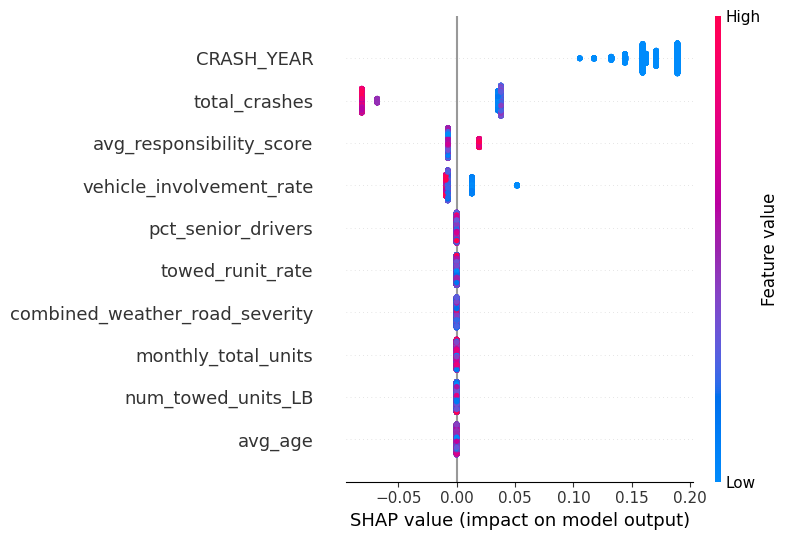

In [36]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt_under.best_estimator_)
shap_values = explainer.shap_values(X_test)


shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

---

# Dropping the most influential feature in the wrong predictions

In [37]:
df_train.drop(columns=['CRASH_YEAR'], inplace=True)
df_test.drop(columns=['CRASH_YEAR'], inplace=True)



C:\Users\chucki\AppData\Local\Temp\ipykernel_8900\1809022388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['CRASH_YEAR'], inplace=True)
C:\Users\chucki\AppData\Local\Temp\ipykernel_8900\1809022388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['CRASH_YEAR'], inplace=True)


In [38]:
X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 23), (19289,), (3227, 23), (3227,))

In [39]:
# dt
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [40]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))

Train accuracy: 0.69
Test accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

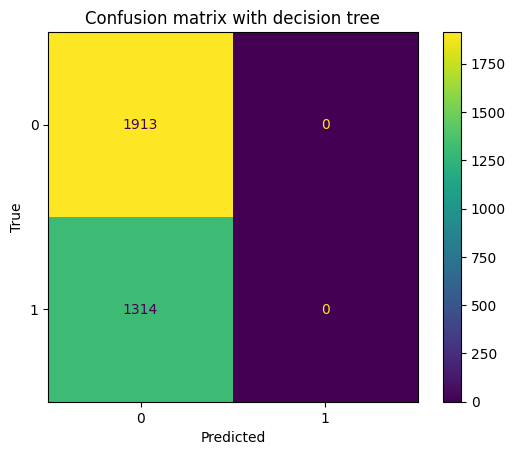

In [41]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')
plt.show()

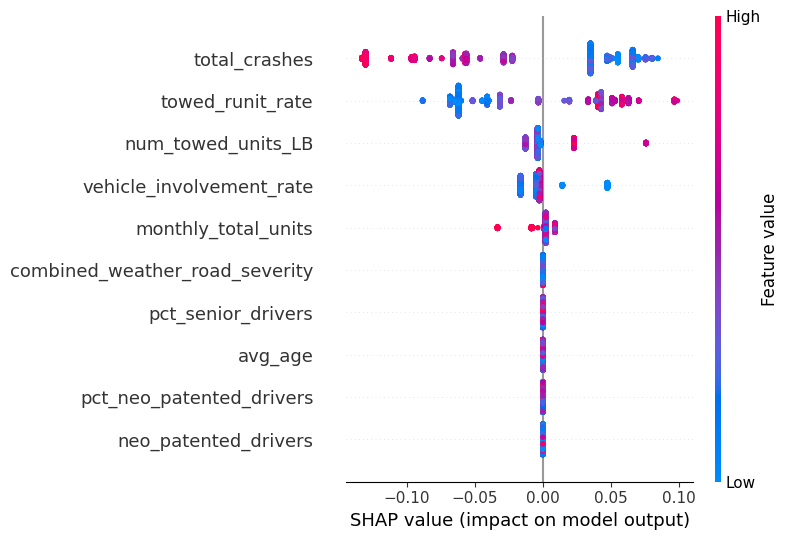

In [55]:
# shap
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

---

### now with undersampling

In [42]:
df_under = pd.concat([df_train[df_train['DAMAGE_HIGH'] == 0].sample(n=df_train['DAMAGE_HIGH'].sum(), random_state=42), df_train[df_train['DAMAGE_HIGH'] == 1]])
df_under.columns

Index(['CRASH_MONTH', 'avg_responsibility_score', 'avg_lighting_severity',
       'total_crashes', 'fatality_rate', 'severe_injury_rate',
       'avg_crash_severity_score', 'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'vehicle_involvement_rate', 'combined_weather_road_severity',
       'towed_runit_rate', 'DAMAGE_HIGH'],
      dtype='object')

In [45]:
X_train_under = df_under.drop(columns=['DAMAGE_HIGH'])
y_train_under = df_under['DAMAGE_HIGH']



In [46]:
# dt
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt_under = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt_under.fit(X_train_under, y_train_under)

grid_dt_under.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [47]:
X_test.columns

Index(['CRASH_MONTH', 'avg_responsibility_score', 'avg_lighting_severity',
       'total_crashes', 'fatality_rate', 'severe_injury_rate',
       'avg_crash_severity_score', 'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'vehicle_involvement_rate', 'combined_weather_road_severity',
       'towed_runit_rate'],
      dtype='object')

In [48]:
print(f"Train accuracy: {grid_dt_under.best_score_:.2f}")
print(f"Test accuracy: {grid_dt_under.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt_under.predict(X_test)))
confusion_matrix(y_test, grid_dt_under.predict(X_test))

Train accuracy: 0.54
Test accuracy: 0.57
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1913
           1       0.48      0.53      0.50      1314

    accuracy                           0.57      3227
   macro avg       0.56      0.57      0.56      3227
weighted avg       0.58      0.57      0.58      3227



array([[1158,  755],
       [ 622,  692]])

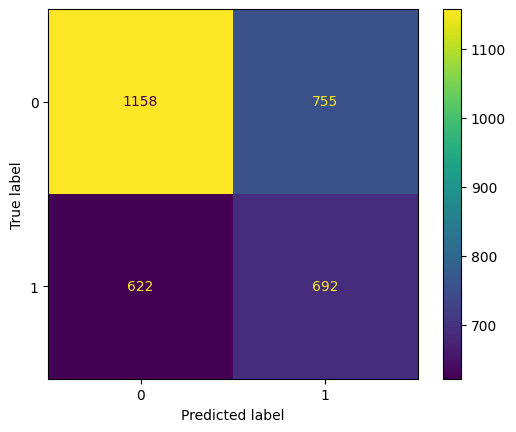

In [49]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm_under = confusion_matrix(y_test, grid_dt_under.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_under, display_labels=grid_dt_under.classes_)
disp.plot()

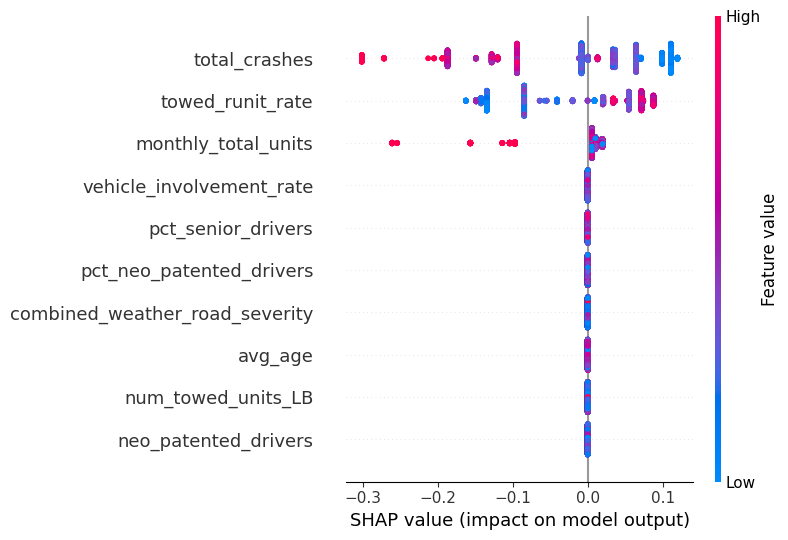

In [50]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt_under.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

---

### Random Forest

In [51]:
# rf
rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_under, y_train_under)

grid_rf.best_params_




Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'n_estimators': 32}

In [55]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))


Train accuracy: 0.58
Test accuracy: 0.58
              precision    recall  f1-score   support

           0       0.66      0.61      0.63      1913
           1       0.48      0.54      0.51      1314

    accuracy                           0.58      3227
   macro avg       0.57      0.57      0.57      3227
weighted avg       0.59      0.58      0.58      3227



array([[1161,  752],
       [ 608,  706]])

Text(0.5, 0, 'Predicted')

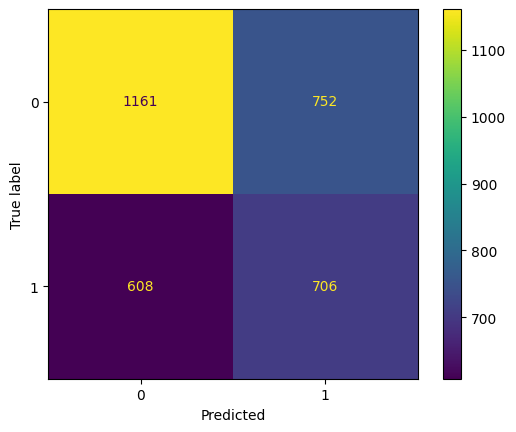

In [56]:

# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')

---

In [ ]:
# XGBoost
from xgboost import XGBClassifier


base_model = XGBClassifier()
hyperparameters_xg = {
    "n_estimators": [25, 100, 250],
    "max_depth": [2, 4, 8],
    "learning_rate": [0.1, 0.001, 0.0001]
}
search = GridSearchCV(base_model, hyperparameters_xg, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train_under, y_train_under)
xg_boost = search.best_estimator_
xg_boost.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [53]:
print(f"Train accuracy: {xg_boost.score(X_train, y_train):.2f}")
print(f"Test accuracy: {xg_boost.score(X_test, y_test):.2f}")
print(classification_report(y_test, xg_boost.predict(X_test)))
confusion_matrix(y_test, xg_boost.predict(X_test))


Train accuracy: 0.80
Test accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[1913,    0],
       [1314,    0]])

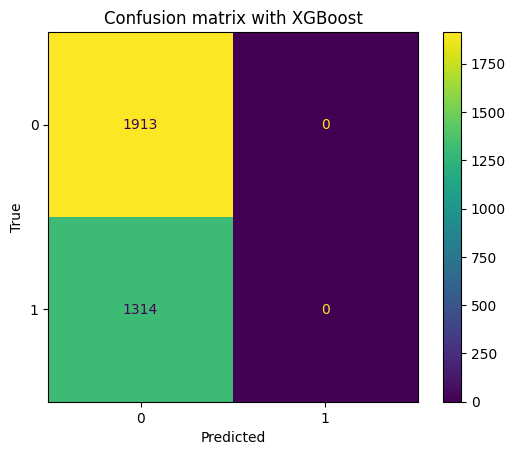

In [54]:
# confusion matrix
cm_xg = confusion_matrix(y_test, xg_boost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xg, display_labels=xg_boost.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with XGBoost')

plt.show()

---

In [56]:
# drop total_crashes column
df_train.drop(columns=['total_crashes'], inplace=True)
df_test.drop(columns=['total_crashes'], inplace=True)

C:\Users\chucki\AppData\Local\Temp\ipykernel_13060\2501323216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['total_crashes'], inplace=True)
C:\Users\chucki\AppData\Local\Temp\ipykernel_13060\2501323216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['total_crashes'], inplace=True)


In [57]:
X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 22), (19289,), (3227, 22), (3227,))

In [58]:
# dt
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))

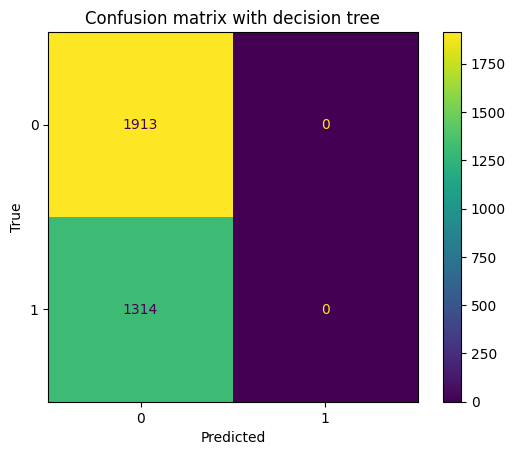

In [59]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)

disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')
plt.show()

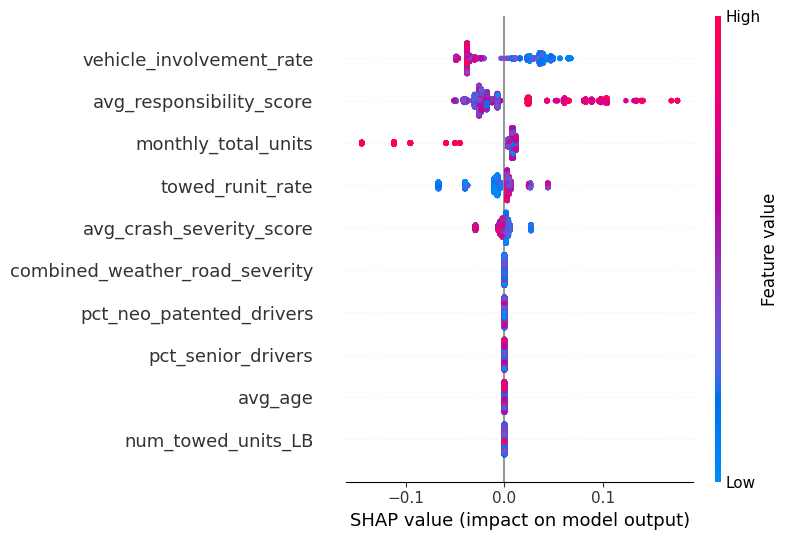

In [60]:
# shap
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

---

### Neural Network

In [62]:
X_test.shape

(3227, 22)

In [64]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape



((19289, 19), (19289,), (3227, 19), (3227,))

In [21]:
X_train.shape

(15431, 24)

In [16]:
from sklearn.model_selection import train_test_split

X_train_full = X_train.copy()
y_train_full = y_train.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [22]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
import tensorflow as tf

def create_model(optimizer='adam', neurons1=128, neurons2=32):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(24,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(neurons1, activation='relu'),
    tf.keras.layers.Dense(neurons2, activation='relu'),  # Second layer
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['accuracy'])
  return model


In [23]:
# Wrap the model
model = KerasClassifier(build_fn=create_model, verbose=0, neurons1=128, neurons2=32)


In [24]:
# k-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

hyperparameters_nn = {
  'optimizer': ['adam'],
  'neurons1' : [64, 128, 256],
  'neurons2' : [32, 64],
  'batch_size': [32],
  'epochs': [7]
}

# grid search
grid_search_nn = GridSearchCV(estimator=model, param_grid=hyperparameters_nn, cv=kf, scoring='f1', n_jobs=-1, verbose=3)


In [25]:
grid_search_nn.fit(X_train, y_train, validation_data=(X_val, y_val))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KerasClassifier(build_fn=<function create_model at 0x0000013AD3431CF0>, neurons1=128, neurons2=32, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [32], 'epochs': [7],
                         'neurons1': [64, 128, 256], 'neurons2': [32, 64],
                         'optimizer': ['adam']},
             scoring='f1', verbose=3)

In [26]:
# Print the best parameters and the best score
print(f"Best parameters: {grid_search_nn.best_params_}")
print(f"Best score: {grid_search_nn.best_score_}")

# Save the training and validation accuracy for the best model
history = grid_search_nn.best_estimator_.model_.history
training_acc = history.history.get('accuracy', [])
validation_acc = history.history.get('val_accuracy', [])

Best parameters: {'batch_size': 32, 'epochs': 7, 'neurons1': 256, 'neurons2': 32, 'optimizer': 'adam'}
Best score: 0.1159115140614618


              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

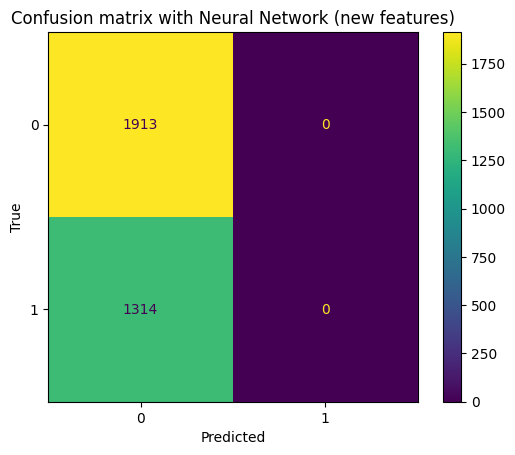

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# evaluation of the best model
best_model = grid_search_nn.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Neural Network (new features)')
plt.show()

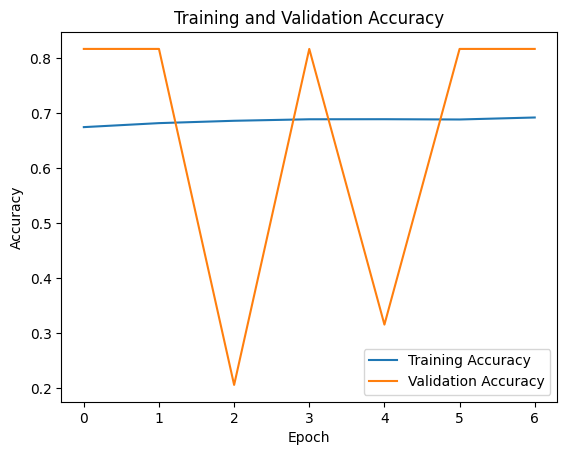

In [29]:
#plot
plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

---